In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
from copy import copy
import string

LETTERS_ENUM = enumerate(list(string.ascii_lowercase))
LETTERS = dict((j,i) for i,j in LETTERS_ENUM)
LETTERS_ENUM = enumerate(list(string.ascii_lowercase))
NUM_TO_LETTER = dict((i,j) for i,j in LETTERS_ENUM)

def nums_to_letters(arr):
    letters = ''
    for num in arr:
        letter = NUM_TO_LETTER[int(num)]
        letters+=letter
    return letters

# load single example
def load_example( img_path ):

    Y = img_path[img_path.rfind('_')+1:-4]

    img = Image.open( img_path )
    img_mat = np.asarray( img )
    
    n_letters = len( Y )
    im_height = int(img_mat.shape[0])
    im_width = int(img_mat.shape[1]/n_letters)
    n_pixels = im_height*im_width
    
    X = np.zeros( [int(n_pixels+n_pixels*(n_pixels-1)/2),n_letters])
    for i in range(n_letters):
        
        # single letter
        letter = img_mat[:,i*im_width:(i+1)*im_width]/255
        
        # compute features
        x = letter.flatten()
        X[0:len(x),i] = x
        cnt = n_pixels 
        for j in range(0,n_pixels-1):
            for k in range(j+1,n_pixels):
                X[cnt,i] = x[j]*x[k]
                cnt = cnt + 1
           
        X[:,i] = X[:,i]/np.linalg.norm(X[:,i])
        
    return X, Y, img
    
# load all examples from a folder    
def load_examples( image_folder ):
    
    files = [f for f in listdir(image_folder) if isfile(join(image_folder, f))]

    X = []
    Y = []
    img = []
    for file in listdir(image_folder):
        path = join(image_folder, file)
        if isfile( path ):
                        
            X_,Y_,img_ = load_example( path )
            X.append( X_ )
            Y.append( Y_ )
            img.append( img_ )
        
    return X, Y, img
    


In [3]:
# load training examples
trn_X, trn_Y, trn_img = load_examples( '/content/drive/MyDrive/ocr_names_images/trn' )

# load testing examples
tst_X, tst_Y, tst_img = load_examples( '/content/drive/MyDrive/ocr_names_images/tst' )


#features=8256
#trn examples=1000
#tst examples=500


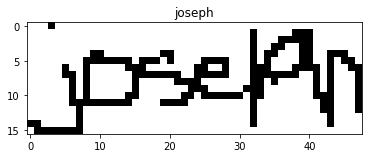

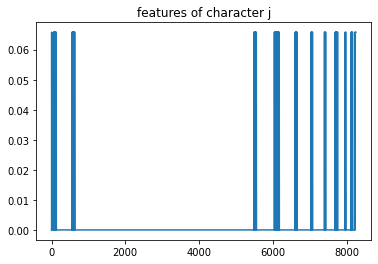

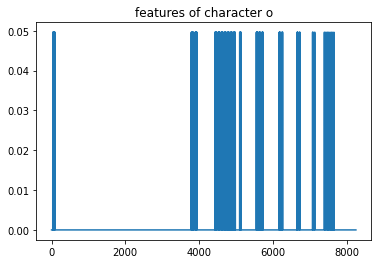

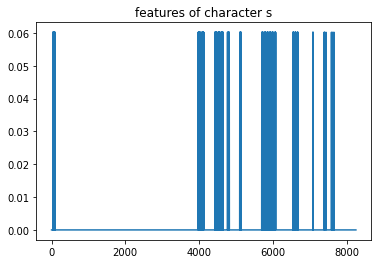

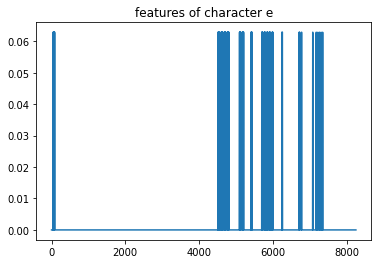

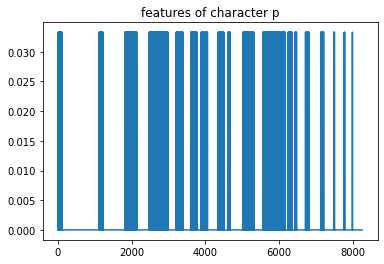

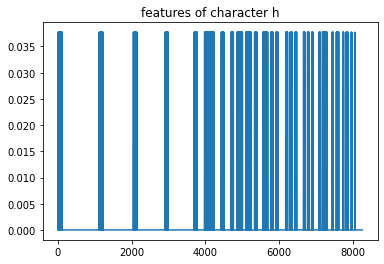

In [4]:
print(f"#features={trn_X[0].shape[0]}")
print(f"#trn examples={len(trn_X)}")
print(f"#tst examples={len(tst_X)}")

# show the first testing example 
plt.figure()
plt.imshow( tst_img[0], cmap='Greys')
plt.title( tst_Y[0] )

for i in range(tst_X[0].shape[1]):
    plt.figure()
    plt.plot( tst_X[0][:,i])
    plt.title(f"features of character {tst_Y[0][i]}")


In [5]:
def independent_linear_classifier(X,y):
    # y .... string .... name
    num_features = copy(X[0].shape[0])

    for i in range(len(X)):
        X[i] = np.concatenate((X[i],np.ones((1,X[i].shape[1]))),axis=0)

    w = np.zeros(((num_features + 1),len(LETTERS)))

    how_we_doing = 0
    misclasses = 0
    
    while True:
        for i in range(len(X)):
            name_features = X[i]
            name_label = y[i]

            for j in range(name_features.shape[1]):
                letter_label = name_label[j]
                letter_num = LETTERS[letter_label]

                letter_features = name_features[:,j]

                X_y = np.zeros(w.shape) # phi(x,y) from presentation
                X_y[:,letter_num] = letter_features
                
                letter_pred = independent_linear_classifier_predict_letter(w,letter_features)
                if letter_pred != letter_label:
                    X_y_correct = X_y
                    X_y_wrong = np.zeros(w.shape)
                    X_y_wrong[:,LETTERS[letter_pred]] = letter_features

                    w = w + X_y_correct - X_y_wrong

                    misclasses += 1
                else:
                    how_we_doing += 1
                
                #hopefully_positive = np.sum(np.multiply(w, X_y))
                
                #if hopefully_positive <= 0:
                #    w = w + X_y
                #    misclasses += 1
                #else:
                #    how_we_doing += 1

        print(how_we_doing,misclasses)

        if misclasses == 0:
            return(w)
            
        how_we_doing = 0 
        misclasses = 0

def independent_linear_classifier_predict_letter(w,X):
    best_letter = ''
    best_score = -np.Inf

    if w[:,0].shape != X.shape:
        X_extended = np.concatenate((X,np.ones((1,))), axis = 0)
    else:
        X_extended = X

    for letter in LETTERS.keys():
        i = LETTERS[letter]
        score = np.sum(np.multiply(w[:,i], X_extended))

        if score > best_score:
            best_score = score
            best_letter = letter
            
    return best_letter


def independent_linear_classifier_predict_name(w,X):
    predicted_name = ''

    for i in range(X.shape[1]):
        features = X[:,i]
        predicted_letter = independent_linear_classifier_predict_letter(w,features)
        predicted_name += predicted_letter

    return predicted_name


In [42]:
def pair_wise_dependent_linear_classifier(X,y):
    # y .... string .... name
    num_features = copy(X[0].shape[0])

    for i in range(len(X)):
        X[i] = np.concatenate((X[i],np.ones((1,X[i].shape[1]))),axis=0)

    w = np.zeros(((num_features + 1),len(LETTERS)))      

    g_w = np.zeros((len(LETTERS),len(LETTERS)))      # parameters of g(y1,y2)

    how_we_doing = 0
    misclasses = 0
    
    while True:
        for i in range(len(X)):
            name_features = X[i]
            name_label = y[i]
            
            #X_y = np.zeros(w.shape) # phi(x,y) from presentation

            #g_matrix = np.zeros(g_w.shape)

            #X_ys = []
            #g_matrices = []

            ''' for j in range(name_features.shape[1]):
                first_letter = name_label[j]

                letter_features = name_features[:,j]
                
                X_y[:,LETTERS[first_letter]] += letter_features

                if j < name_features.shape[1]-1:
                    following_letter = name_label[j+1]

                    g_matrix[LETTERS[first_letter]][LETTERS[following_letter]] = 1 '''
            
            ''' for j in range(name_features.shape[1]):
                first_letter = name_label[j]

                letter_features = name_features[:,j]
                
                X_y[:,LETTERS[first_letter]] = letter_features
                X_ys.append() '''

            ''' if j < name_features.shape[1]-1:
                    following_letter = name_label[j+1]

                    g_matrix[LETTERS[first_letter]][LETTERS[following_letter]] = 1 '''
            
            name_pred = pair_wise_predict_name(w,g_w,name_features)

            if name_pred != name_label:
                for l in range(len(name_pred)):
                    letter_pred = name_pred[l]
                    letter_label = name_label[l]

                    #print(name_pred)
                    #print(name_label)
                    
                    if letter_pred != letter_label:
                        letter_pred_ind = LETTERS[letter_pred]
                        letter_label_ind = LETTERS[letter_label]

                        w[:,letter_pred_ind] -= name_features[:,l]
                        w[:,letter_label_ind] += name_features[:,l]

                        if l > 0:
                            prev_letter = name_label[l-1]
                            prev_letter_ind = LETTERS[prev_letter]
                            g_w[prev_letter_ind,letter_pred_ind] -= 0.1
                            g_w[prev_letter_ind,letter_label_ind] += 0.1

                misclasses += 1
            else:
                how_we_doing += 1

            #feature_map_hopefully_positive = np.sum(np.multiply(w1, X_y))

            #pair_wise_dep_hopefully_positive = np.sum(np.multiply(w2, g_helper_matrix))

            #hopefully_positive = feature_map_hopefully_positive + pair_wise_dep_hopefully_positive
            
            #if hopefully_positive <= 0:
            #    w1 = w1 + X_y
            #    w2 = w2 + g_helper_matrix
            #    misclasses += 1
            #else:
            #    how_we_doing += 1

        print(how_we_doing,misclasses)

        if misclasses == 0:
            return(w,g_w)
            
        how_we_doing = 0 
        misclasses = 0
        
def pair_wise_predict_name(w,g_w,Xs):
    L = Xs.shape[1]
    qs = w.T @ Xs     # 26*L ... q-score for letter per feature vector
    letter_scores = np.zeros((len(LETTERS),L))    # 26*L ... best score so far per letter (row) per character_position (col)
    best_prev_letter = np.zeros((len(LETTERS),L-1))

    letter_scores[:,0] = qs[:,0]    # first row is just q score

    for i in range(L-1):
        col = i+1
        for j in range(len(LETTERS)):
            max_score = -np.Inf
            argmax_letter =  ''

            feature_score = qs[j,col]

            #for k in range(len(LETTERS)):
            pair_wise_score = letter_scores[:,i] + g_w[:,j]
            
            score = feature_score + np.max(pair_wise_score)

            #if score > max_score:
            #    max_score = score
            #    argmax_letter = NUM_TO_LETTER(np.argmax(pair_wise_score))

            letter_scores[j,col] = score
            best_prev_letter[j,col-1] = int(np.argmax(pair_wise_score))

    name_pred = np.zeros(L)
    letter_memory = None
    for i in range(L):
        if letter_memory is None:
            letter_memory = int(np.argmax(letter_scores[:,-1]))
        name_pred[L-1-i] = letter_memory

        if i < L-1:
            letter_memory = int(best_prev_letter[letter_memory,L-2-i])

    name_pred = nums_to_letters(name_pred)

    return name_pred

In [7]:
def fixed_number_sequence_linear_classifier(X,y):
    # y .... string .... name

    # Get all unique names and separate them by length:
    unique_names = np.unique(trn_Y)
    unique_names_dict = {}

    for name in unique_names:
        try:
            unique_names_dict[len(name)].append(name)
        except:
            unique_names_dict[len(name)] = [name]

    num_features = copy(X[0].shape[0])

    for i in range(len(X)):
        X[i] = np.concatenate((X[i],np.ones((1,X[i].shape[1]))),axis=0)

    w1 = np.zeros(((num_features + 1),len(LETTERS)))      

    w2 = np.zeros((len(LETTERS),len(LETTERS)))      # parameters of g(y1,y2)

    how_we_doing = 0
    misclasses = 0
    
    while True:
        for i in range(len(X)):
            name_features = X[i]
            name_label = y[i]
            
            X_y = np.zeros(w1.shape) # phi(x,y) from presentation

            g_helper_matrix = np.zeros(w2.shape)

            for j in range(name_features.shape[1]):
                first_letter = name_label[j]

                letter_features = name_features[:,j]
                
                X_y[:,LETTERS[first_letter]] += letter_features

                if j < name_features.shape[1]-1:
                    following_letter = name_label[j+1]

                    g_helper_matrix[LETTERS[first_letter]][LETTERS[following_letter]] = 1

            feature_map_hopefully_positive = np.sum(np.multiply(w1, X_y))

            pair_wise_dep_hopefully_positive = np.sum(np.multiply(w2, g_helper_matrix))

            hopefully_positive = feature_map_hopefully_positive + pair_wise_dep_hopefully_positive
            
            if hopefully_positive <= 0:
                w1 = w1 + X_y
                w2 = w2 + g_helper_matrix
                misclasses += 1
            else:
                how_we_doing += 1

        print(how_we_doing,misclasses)

        if misclasses == 0:
            return(w1,w2)
            
        how_we_doing = 0 
        misclasses = 0
        
    

In [8]:
def evaluate_seq(Y_true,Y_pred):
    hits = 0
    for i in range(len(Y_true)):
        y_true = Y_true[i]
        y_pred = Y_pred[i]
        if y_true == y_pred:
            hits += 1
    
    return (len(Y_true)-hits)/len(Y_true)

def evaluate_chars(Y_true,Y_pred):
    hits = 0
    total_chars = 0
    for i in range(len(Y_true)):
        y_true = Y_true[i]
        y_pred = Y_pred[i]

        total_chars += len(y_true)

        for j in range(len(y_true)):
            if y_true[j] == y_pred[j]:
                hits += 1
    
    return (total_chars-hits)/total_chars

In [38]:
w_opt_1 = independent_linear_classifier(copy(trn_X), copy(trn_Y))


#[w_opt_2_1, w_opt_2_2] = pair_wise_dependent_linear_classifier(copy(trn_X), copy(trn_Y))

KeyboardInterrupt: ignored

In [45]:
predicted_names = []

for i in range(len(copy(tst_X))):
    X = copy(tst_X)[i]
    predicted_name = independent_linear_classifier_predict_name(w_opt_1,X)
    predicted_names.append(predicted_name)

R_seq = evaluate_seq(copy(tst_Y), predicted_names)
R_char = evaluate_chars(copy(tst_Y), predicted_names)

print("Independent linear classifier: R_seq = {}, R_char = {}".format(round(R_seq,3), round(R_char,3)))

IndexError: ignored

In [43]:
w_opt_2,g_w_opt_2 = pair_wise_dependent_linear_classifier(copy(trn_X), copy(trn_Y))


419 581
789 211
898 102
928 72
966 34
959 41
973 27
970 30
977 23
993 7
999 1
999 1
1000 0


In [49]:
predicted_names = []

X = copy(tst_X)

for i in range(len(X)):
    X[i] = np.concatenate((X[i],np.ones((1,X[i].shape[1]))),axis=0)

for i in range(len(X)):
    name_features = X[i]
    
    predicted_name = pair_wise_predict_name(w_opt_2,g_w_opt_2,name_features)
    predicted_names.append(predicted_name)

R_seq = evaluate_seq(copy(tst_Y), predicted_names)
R_char = evaluate_chars(copy(tst_Y), predicted_names)

print("Independent linear classifier: R_seq = {}, R_char = {}".format(round(R_seq,3), round(R_char,3)))

Independent linear classifier: R_seq = 0.164, R_char = 0.087
